# Text Classification - BBC News Data

## Overview

The following notebook is created out of inspiration from the source [here](https://colab.research.google.com/github/srushtidhope/bbc-text-classification/blob/master/bbc_text_classification.ipynb#scrollTo=22L7TrqYtFiz) 


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# NLTK modules
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import re

from gensim.models import Word2Vec # Word2Vec module

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

C:\Users\amakr\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\amakr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amakr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\amakr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Dataset

In [3]:
news_data = pd.read_csv('../Translated/cleaned/train.csv')
test = pd.read_csv('../Translated/cleaned/test.csv')
trans = pd.read_csv('../Notebooks/corpus_translated.csv')
trans = trans.iloc[:,1]
# trans
news_data['Text'] = trans[:news_data.shape[0]]
test['Text'] = trans[news_data.shape[0]:]


In [4]:
print(f"Shape : {news_data.shape}, \n\nColumns: {news_data.columns}, \n\nCategories: {news_data.Label.unique()}")

# print sample data
news_data.head().append(news_data.tail())

Shape : (1436, 3), 

Columns: Index(['ID', 'Text', 'Label'], dtype='object'), 

Categories: ['POLITICS' 'HEALTH' 'LAW/ORDER' 'RELIGION' 'FARMING'
 'WILDLIFE/ENVIRONMENT' 'SOCIAL ISSUES' 'SOCIAL' 'OPINION/ESSAY'
 'LOCALCHIEFS' 'WITCHCRAFT' 'ECONOMY' 'SPORTS' 'RELATIONSHIPS' 'TRANSPORT'
 'CULTURE' 'EDUCATION' 'MUSIC' 'ARTS AND CRAFTS' 'FLOODING']


,ID,Text,Label
0,ID_AASHwXxg,when a young councilor says that the youth and...,POLITICS
1,ID_AGoFySzn,mcp is not satisfied with the registration of ...,POLITICS
2,ID_AGrrkBGP,The Network of Older Persons Organization (AP)...,HEALTH
3,ID_AIJeigeG,extremist politics are not uncommon to hear th...,POLITICS
4,ID_APMprMbV,It is not uncommon for a police officer to be ...,LAW/ORDER
1431,ID_zmTmmEio,minibus owners say they have the right to rais...,TRANSPORT
1432,ID_znOlIaGQ,Politicians and non-governmental organizations...,POLITICS
1433,ID_znracTjN,mawu supports non fiction writers the malawi w...,EDUCATION
1434,ID_ztdsmmva,tame mwawa pwete then his eating drama is dyin...,SOCIAL ISSUES
1435,ID_zteydTpN,The House of Representatives is meeting in Bla...,POLITICS


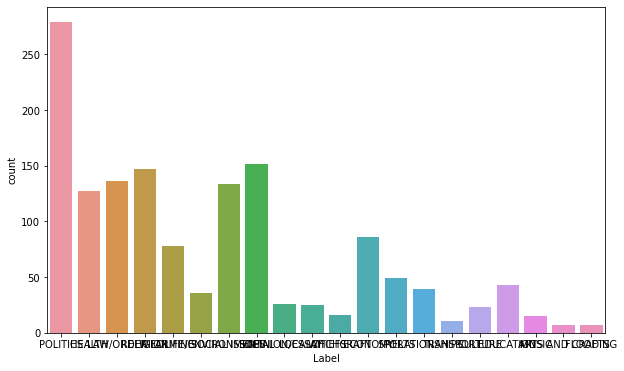

In [6]:
# Plot category data
plt.figure(figsize=(10,6))
sns.countplot(news_data.Label)
plt.show()

## Data Preparation

In [9]:
class DataPreparation:
    def __init__(self, data, column='Text'):
        self.df = data
        self.column = column
    
    def preprocess(self):
        self.tokenize()
        self.remove_stopwords()
        self.remove_non_words()
        self.lemmatize_words()
        
        return self.df
    
    def tokenize(self):
        self.df['clean_text'] = self.df[self.column].apply(nltk.word_tokenize)
        print("Tokenization is done.")
    
    def remove_stopwords(self):
        stopword_set = set(nltk.corpus.stopwords.words('english'))
        
        rem_stopword = lambda words: [item for item in words if item not in stopword_set]
        
        self.df['clean_text'] = self.df['clean_text'].apply(rem_stopword)
        print("Remove stopwords done.")
    
    def remove_non_words(self):
        """
            Remove all non alpha characters from the text data
            :numbers: 0-9
            :punctuation: All english punctuations
            :special characters: All english special characters
        """
        regpatrn = '[a-z]+'
        rem_special_chars = lambda x: [item for item in x if re.match(regpatrn, item)]
        self.df['clean_text'] = self.df['clean_text'].apply(rem_special_chars)
        print("Removed non english characters is done.")
        
    def lemmatize_words(self):
        lemma = nltk.stem.wordnet.WordNetLemmatizer()
        
        on_word_lemma = lambda x: [lemma.lemmatize(w, pos='v') for w in x]
        
        self.df['clean_text'] = self.df['clean_text'].apply(on_word_lemma)
        print("Lemmatization on the words.")

In [10]:
data_prep = DataPreparation(news_data)

cleanse_df = data_prep.preprocess()

Tokenization is done.
Remove stopwords done.
Removed non english characters is done.
Lemmatization on the words.


In [11]:
cleanse_df['clean_text']

0       [young, councilor, say, youth, leaders, tomorr...
1       [mcp, satisfy, registration, malawi, congress,...
2       [call, government, agencies, provide, better, ...
3       [extremist, politics, uncommon, hear, politici...
4       [uncommon, police, officer, state, shock, unco...
                              ...                        
1431    [minibus, owners, say, right, raise, price, on...
1432    [non-governmental, organizations, apologize, i...
1433    [mawu, support, non, fiction, writers, malawi,...
1434    [tame, mwawa, pwete, eat, drama, die, one, gam...
1435    [meet, discuss, issue, regional, councils, aus...
Name: clean_text, Length: 1436, dtype: object

## Feature Engineering

In [12]:
vec_model = Word2Vec(cleanse_df['clean_text'])

w2v = dict(zip(vec_model.wv.index2word, vec_model.wv.syn0))

## Classification with Custom Vectorizer

In [13]:
class Vectorizer(object):
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])
    

    

# Classifier class
class Classifier(object):
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gsearch = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)
        
    def fit(self, X, y):
        return self.gsearch.fit(X, y)
    
    def predict(self, X):
        return self.gsearch.predict(X)

clf_models = {
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}

clf_params = {
    'Naive Bayes': {},
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'activation': ['tanh', 'relu']}
}

## Split the dataset

In [14]:
cleanse_df

,ID,Text,Label,clean_text
0,ID_AASHwXxg,when a young councilor says that the youth and...,POLITICS,"[young, councilor, say, youth, leaders, tomorr..."
1,ID_AGoFySzn,mcp is not satisfied with the registration of ...,POLITICS,"[mcp, satisfy, registration, malawi, congress,..."
2,ID_AGrrkBGP,The Network of Older Persons Organization (AP)...,HEALTH,"[call, government, agencies, provide, better, ..."
3,ID_AIJeigeG,extremist politics are not uncommon to hear th...,POLITICS,"[extremist, politics, uncommon, hear, politici..."
4,ID_APMprMbV,It is not uncommon for a police officer to be ...,LAW/ORDER,"[uncommon, police, officer, state, shock, unco..."
...,...,...,...,...
1431,ID_zmTmmEio,minibus owners say they have the right to rais...,TRANSPORT,"[minibus, owners, say, right, raise, price, on..."
1432,ID_znOlIaGQ,Politicians and non-governmental organizations...,POLITICS,"[non-governmental, organizations, apologize, i..."
1433,ID_znracTjN,mawu supports non fiction writers the malawi w...,EDUCATION,"[mawu, support, non, fiction, writers, malawi,..."
1434,ID_ztdsmmva,tame mwawa pwete then his eating drama is dyin...,SOCIAL ISSUES,"[tame, mwawa, pwete, eat, drama, die, one, gam..."


In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(cleanse_df['clean_text'], cleanse_df['Label'], test_size=0.2, shuffle=True)

In [16]:
# Iterate through the model names
for key in clf_models.keys():
    
    clf = Pipeline([('Word2Vec', Vectorizer(w2v)), ('Classifier', Classifier(clf_models[key], clf_params[key]))])
    
    # Fitting the data
    clf.fit(X_train, y_train)
    
    y_preds = clf.predict(X_valid)
    
    
    print(key, ":")
    print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_valid, y_preds),
                                                                                     precision_score(y_valid, y_preds, average='macro'),
                                                                                     recall_score(y_valid, y_preds, average='macro'),
                                                                                     f1_score(y_valid, y_preds, average='macro')))

Naive Bayes :
Accuracy: 0.188 	Precision: 0.220 	Recall: 0.186 	F1-Score: 0.137

SVC :
Accuracy: 0.292 	Precision: 0.121 	Recall: 0.098 	F1-Score: 0.071

Decision Tree :
Accuracy: 0.354 	Precision: 0.232 	Recall: 0.224 	F1-Score: 0.222

SGD Classifier :
Accuracy: 0.403 	Precision: 0.313 	Recall: 0.203 	F1-Score: 0.216

Perceptron :
Accuracy: 0.434 	Precision: 0.183 	Recall: 0.209 	F1-Score: 0.191



## Vectorization using TFIDF

In [17]:
def vectorize(vector, X_train, X_test):
    vector_fit = vector.fit(X_train)
    
    X_train_vec = vector_fit.transform(X_train)
    X_test_vec = vector_fit.transform(X_test)
    
    print("Vectorization is completed.")
    return X_train_vec, X_test_vec

def label_encoding(y_train):
    """
        Encode the given list of class labels
        :y_train_enc: returns list of encoded classes
        :labels: actual class labels
    """
    lbl_enc = LabelEncoder()
    
    y_train_enc = lbl_enc.fit_transform(y_train)
    labels = lbl_enc.classes_
    
    return y_train_enc, labels

def algorithm_stack(models, params, X_train, X_test, y_train, y_test):
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Keys do not match')
        
    for key in models.keys():
        model = models[key]
        param = params[key]
        
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        
        y_pred = gs.predict(X_test)
        
        print(key, ":")
        print("Accuracy: %1.3f \tPrecision: %1.3f \tRecall: %1.3f \tF1-Score: %1.3f\n" % (accuracy_score(y_test, y_pred),
                                                                                     precision_score(y_test, y_pred, average='macro'),
                                                                                     recall_score(y_test, y_pred, average='macro'),
                                                                                     f1_score(y_test, y_pred, average='macro')))
    return


In [18]:
# Encode the class labels
y_enc_train, labels = label_encoding(news_data['Label'])

# Split from the loaded dataset
X_train, X_valid, y_train, y_test = train_test_split(news_data['Text'], y_enc_train, test_size=0.2, shuffle=True,random_state = 0)

# TFIDFVectorizer 
X_train_vec, X_valid_vec = vectorize(TfidfVectorizer(), X_train, X_valid)

print(X_train_vec.shape, X_valid_vec.shape)

clf_models = {
    'Naive Bayes': MultinomialNB(),
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'SGD Classifier': SGDClassifier(),
    'Perceptron': MLPClassifier()
}


# Modified parameters
clf_params = {
    'Naive Bayes': {'alpha': [0.5, 1], 'fit_prior': [True, False] },
    'SVC' : {'kernel': ['linear', 'rbf']},
    'Decision Tree': {'min_samples_split': [1, 2, 5]},
    'SGD Classifier': { 'penalty': ['l2', 'l1', 'elasticnet'] },
    'Perceptron': {'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu']}
}

Vectorization is completed.
(1148, 12564) (288, 12564)


In [19]:
y_train

array([15,  7,  2, ..., 11,  3, 13])

In [20]:
algorithm_stack(clf_models, clf_params, X_train_vec, X_valid_vec, y_train, y_test)

Naive Bayes :
Accuracy: 0.351 	Precision: 0.287 	Recall: 0.165 	F1-Score: 0.160

SVC :
Accuracy: 0.604 	Precision: 0.444 	Recall: 0.409 	F1-Score: 0.412

Decision Tree :
Accuracy: 0.403 	Precision: 0.294 	Recall: 0.326 	F1-Score: 0.294

SGD Classifier :
Accuracy: 0.562 	Precision: 0.480 	Recall: 0.498 	F1-Score: 0.461

Perceptron :
Accuracy: 0.615 	Precision: 0.490 	Recall: 0.429 	F1-Score: 0.433

